### Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import random
import os

# Reproducibility
seed = 2
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Optional: disable eager execution (if using graph mode code)
tf.compat.v1.disable_eager_execution()

# Session config
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(config=session_conf)

# Set this session as default for everything that follows
# No set_session needed — use a context manager instead
with sess.as_default():
    # your model/code here
    pass


2025-05-04 15:41:09.488275: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 15:41:09.502359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746373269.516937 2370151 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746373269.521088 2370151 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746373269.532583 2370151 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import warnings
warnings.filterwarnings('ignore')

from pylab import *

import pandas as pd
import pickle
import time
import sys
import json
import os

# import statsmodels
# import statsmodels.api as sm
# from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, GRU, Dropout, TimeDistributed
from keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D 
#from keras.layers.convolutional import Conv1D
#from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, ProgbarLogger

### Import Classes

In [3]:
os.getcwd()

'/mnt/c/Users/ansel/AppData/Local/Programs/Microsoft VS Code'

In [4]:
os.chdir('/mnt/d/GitHub/WQU-Capstone/notebooks/classes')

os.getcwd()

'/mnt/d/GitHub/WQU-Capstone/notebooks/classes'

In [5]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor, class_ForecastingTrader
%autoreload 1

I0000 00:00:1746373273.622142 2370151 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9444 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()
forecasting_trader = class_ForecastingTrader.ForecastingTrader()

Function to evaluate forecasting results:

In [7]:
def evaluate_forecasting(n_pairs, true_values, prediction_values):
    mse, mae, rmse, accuracy, bias = list(), list(), list(), list(), list()
    std_dev = list()
    for i in range(n_pairs):
        mse.append(mean_squared_error(true_values[i], prediction_values[i]))
        rmse.append(np.sqrt(mean_squared_error(true_values[i], prediction_values[i])))
        mae.append(mean_absolute_error(true_values[i], prediction_values[i]))
        accuracy.append(forecasting_trader.calculate_direction_accuracy(true_values[i], prediction_values[i]))
        bias.append((true_values[i] - prediction_values[i]).mean())
        std_dev.append(prediction_values[i].std())
    print('{:.2f}E-4'.format(np.mean(mse)*10000))#Average MSE: 
    print('{:.2f}E-3'.format(np.mean(rmse)*1000))#Average RMSE: 
    print('{:.2f}E-3'.format(np.mean(mae)*1000))#Average RMSE: 
    print('{:.2f}%'.format(np.mean(accuracy)))#Average Directional Accuracy: 
    #print('Bias: {:.2f}E-4'.format(np.mean(bias)*10000))
    #print('Average Standard Deviation from prediction signal ', np.mean(std_dev))
    
    return mse, mae, rmse, accuracy

### LSTM

In [8]:
def plot_loss(history, title, epoch_stop, metric='mse'):
    """
    Function to plot loss function.
    Arguments:
    history: History object with data from training.
    title: Plot title.
    """
    plt.figure(figsize=(7,5))
    #plt.grid()
    if metric == 'mse':
        plt.plot(history['loss'], label = "Training MSE")
        plt.plot(history['val_loss'], label = "Validation MSE")
        plt.plot([epoch_stop], [history['val_loss'][epoch_stop]],'o', color='Red', markersize=7)
        plt.annotate(
            'Best Epoch: 41\nValidation MSE:{:.3f}'.format(history['val_loss'][epoch_stop]),
            xy=(epoch_stop, history['val_loss'][epoch_stop]),
            xytext=(-20, 20),
            textcoords='offset points', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='grey', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        plt.ylim((0,1.2))
        plt.ylabel('Mean Squared Error', size=12)
    elif metric == 'mae':
        plt.plot(history['mean_absolute_error'], label = "Training MAE")
        plt.plot(history['val_mean_absolute_error'], label = "Validation MAE")
        plt.plot([epoch_stop], [history['val_mean_absolute_error'][epoch_stop]],'o', color='Red', markersize=7)
        plt.annotate(
            'Best Epoch: 41\nValidation MAE:{:.3f}'.format(history['val_mean_absolute_error'][epoch_stop]),
            xy=(epoch_stop, history['val_mean_absolute_error'][epoch_stop]),
            xytext=(-20, 20),
            textcoords='offset points', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='grey', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        plt.ylim((0,1.2))
        plt.ylabel('Mean Absolute Error', size=12)
    plt.xlabel('Epochs', size=12)
    plt.legend()
    plt.savefig('{}_history.png'.format(metric), bbox='tight')
    
def plot_predictions(summaries):
    
    n_pairs = len(summaries)
    fig, ax = plt.subplots(n_pairs, 1, figsize=(20,25))
    
    for i in range(n_pairs):
        #title('Pair: {}'.format(i))
        predictions = summaries[i]['prediction(t)']
        spread = summaries[i]['spread(t)']
        ax[i].plot(predictions, 'b')
        ax[i].plot(spread, 'r')
    return None

In [9]:
def read_models(path='models/'):
    all_models = [] # Creates an empty list
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".pkl"):
                with open(path+file, 'rb') as f:
                    models = pickle.load(f)
                all_models.append(models)
                
    return all_models

In [ ]:
current_path=('/mnt/d/GitHub/WQU-Capstone/data/')
with open(current_path+'yf_5_clusters_pairs_category.pickle', 'rb') as handle: 
    pairs = pickle.load(handle)
len(pairs)

135

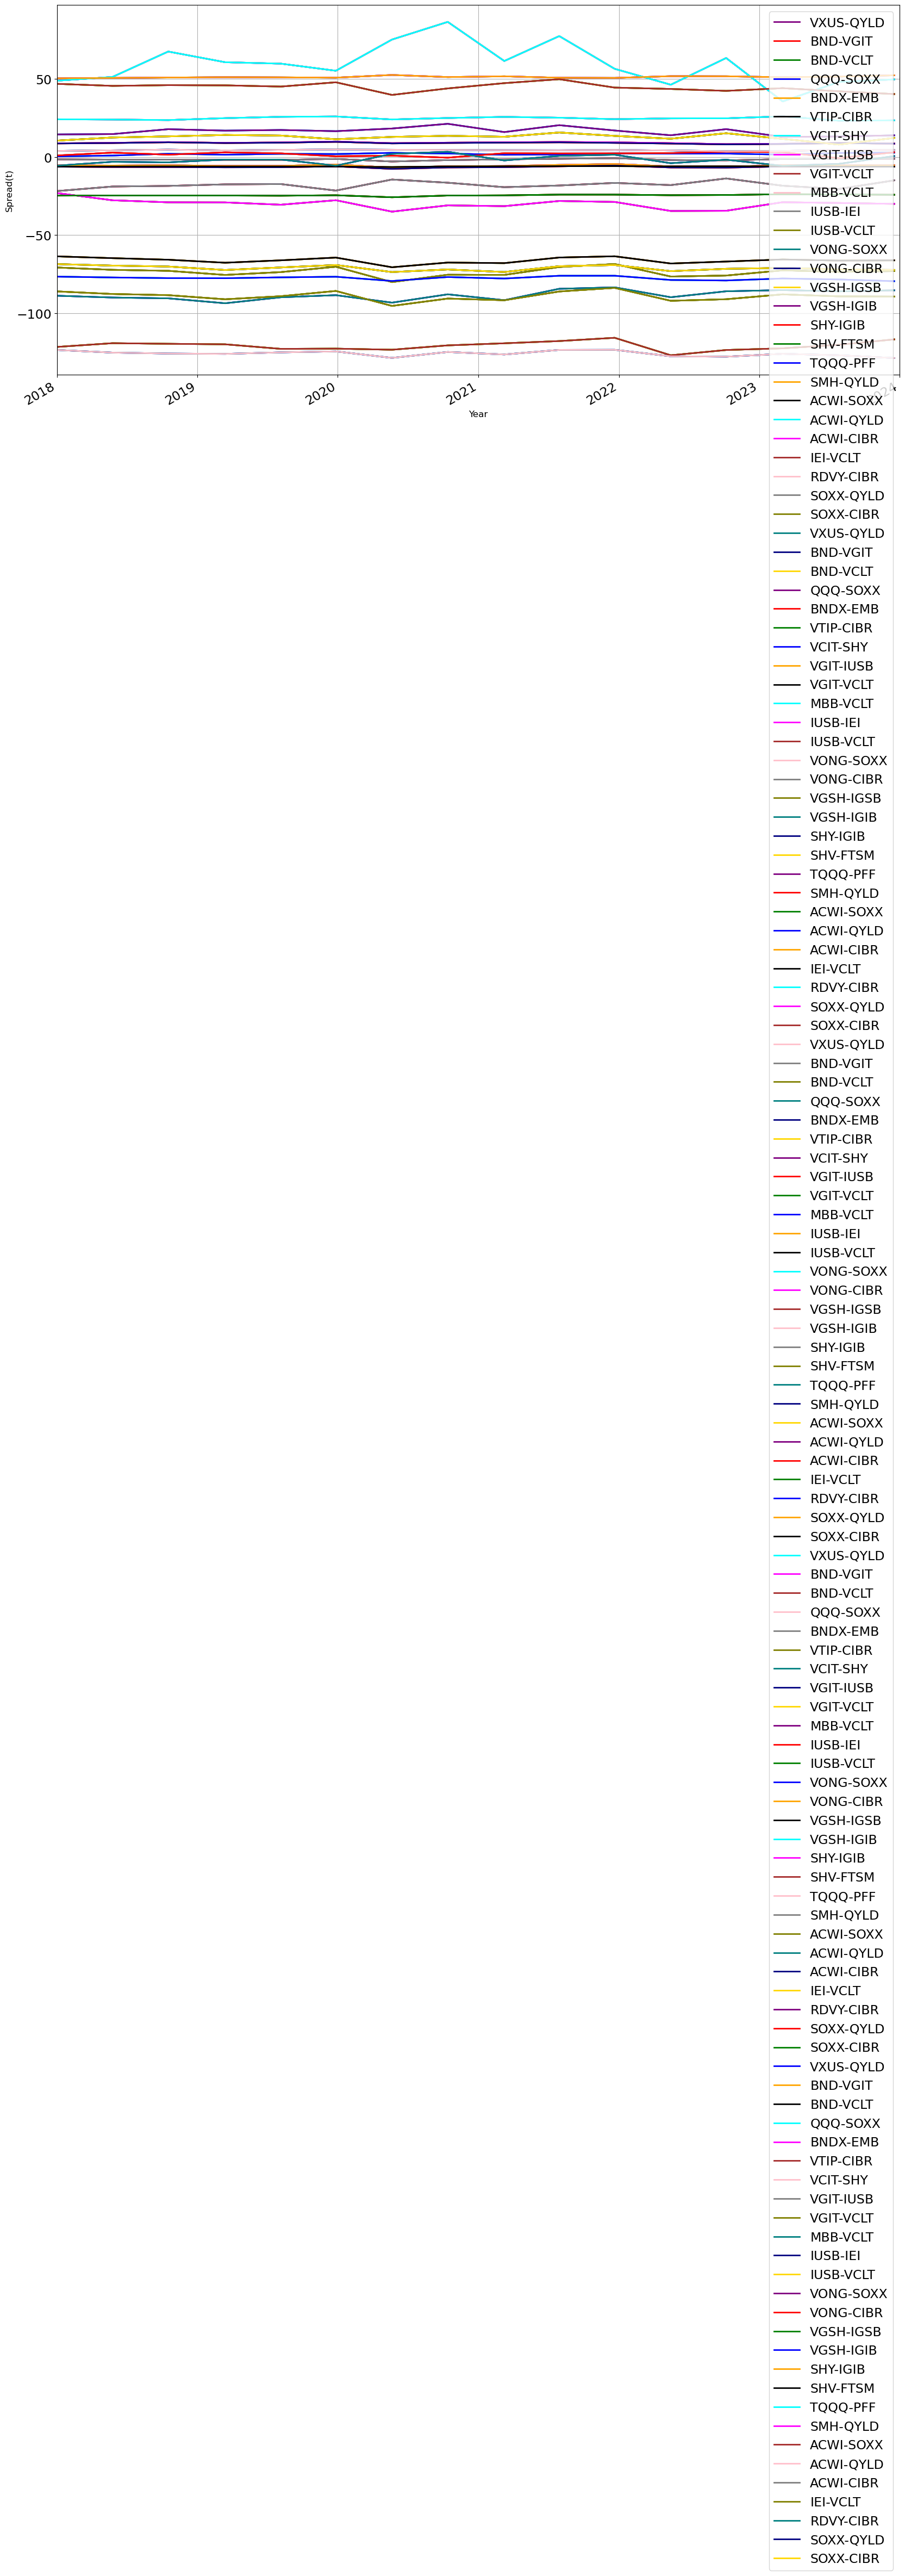

In [11]:
#markers= ["o","s","+","x","<"]
plt.rcParams.update({'font.size': 17})
colors = [
    'purple', 'red', 'green', 'blue', 'orange',
    'black', 'cyan', 'magenta', 'brown', 'pink',
    'gray', 'olive', 'teal', 'navy', 'gold'
]
for i in range(len(pairs)):
    pairs[i][2]['spread'][::100].plot(figsize=(20,10), grid=True, label='{}-{}'.format(pairs[i][0],pairs[i][1]), c=colors[i % len(colors)], linewidth=2)
plt.ylabel('Spread(t)',size=12)
plt.xlabel('Year',size=12)
plt.xlim(('2018', '2024'))
plt.legend()
#plt.savefig('spreads.png', bbox_inches='tight', pad_inches=0.05)

## Grid Search

In [12]:
rnn_models = read_models(path=current_path) 
rnn_models

[{'VXUS':                Close      High       Low      Open    Volume       RSI  \
  Date                                                                     
  2018-03-13  0.452380  0.444528  0.461121  0.457832  0.024600  0.426934   
  2018-03-14  0.456096  0.444018  0.462608  0.459576  0.011080  0.444616   
  2018-03-15  0.454114  0.440447  0.462855  0.452602  0.015261  0.434411   
  2018-03-16  0.451389  0.434837  0.461864  0.447620  0.007255  0.419833   
  2018-03-19  0.439005  0.425401  0.444515  0.441643  0.024682  0.356469   
  ...              ...       ...       ...       ...       ...       ...   
  2024-12-24  0.850981  0.844442  0.854974  0.851405  0.672903  0.295868   
  2024-12-26  0.854659  0.848860  0.861108  0.850788  0.167076  0.318111   
  2024-12-27  0.850675  0.845073  0.856508  0.846473  0.153367  0.300407   
  2024-12-30  0.838414  0.836552  0.843932  0.836918  0.267605  0.248758   
  2024-12-31  0.836268  0.837183  0.845773  0.840000  0.276625  0.240070   
  
 

In [13]:
etf_list = pd.read_excel('/mnt/d/GitHub/WQU-Capstone/data/etf_list.xlsx')
ticker_segment_dict = dict(zip(etf_list['Symbol'], etf_list['Name']))
ticker_segment_dict

{'VXUS': 'Vanguard Total International Stock Index Fund ETF Shares',
 'BND': 'Vanguard Total Bond Market Index Fund',
 'QQQ': 'Invesco QQQ Trust',
 'BNDX': 'Vanguard Total International Bond Index Fund',
 'VTIP': 'Vanguard Short-Term Inflation-Protected Securities Index Fund ETF Shares',
 'VCIT': 'Vanguard Intermediate-Term Corporate Bond Index Fund ETF Shares',
 'TLT': 'iShares 20+ Year Treasury Bond ETF',
 'VCSH': 'Vanguard Short-Term Corporate Bond Index Fund ETF Shares',
 'VGIT': 'Vanguard Intermediate-Term Treasury Index Fund ETF Shares',
 'MBB': 'iShares MBS ETF',
 'IEF': 'iShares 7-10 Year Treasury Bond ETF',
 'IUSB': 'iShares Core Total USD Bond Market ETF',
 'VONG': 'Vanguard Russell 1000 Growth Index Fund ETF Shares',
 'VGSH': 'Vanguard Short-Term Treasury Index Fund ETF Shares',
 'SHY': 'iShares 1-3 Year Treasury Bond ETF',
 'IGSB': 'iShares 1-5 Year Investment Grade Corporate Bond ETF',
 'SHV': 'iShares Short Treasury Bond ETF',
 'TQQQ': 'ProShares UltraPro QQQ',
 'SMH': 'V

In [14]:
# model to test
n_in = 24
hidden_nodes = [50]
low_quantile = 0.10
high_quantile = 0.90
train_val_split = '01-01-2023'

In [15]:
model_rnn, cumret_val, sharperatio_val,summaries_rnn, balance_summaries_rnn = \
            forecasting_trader.run_specific_model(
                                                n_in, 
                                                hidden_nodes, 
                                                pairs,
                                                path='/mnt/d/GitHub/WQU-Capstone/models/lstm/',#/mnt/d/GitHub/WQU-Capstone/models/lstm/',
                                                train_val_split=train_val_split,
                                                low_quantile=low_quantile, 
                                                high_quantile=high_quantile, 
                                                lag=1,
                                                )

Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not cons

In [16]:
performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(pairs))]
performance_rnn

[(            prediction(t)  prediction(t+1)  spread(t)  predicted_change(%)  \
  Date                                                                         
  2023-01-03       1.494010                0   1.390908             0.000000   
  2023-01-04       1.413579                0   1.248552             1.629949   
  2023-01-05       1.273831                0   1.228835             2.024673   
  2023-01-06       1.233824                0   1.228140             0.406013   
  2023-01-09       1.230215                0   1.214597             0.169027   
  ...                   ...              ...        ...                  ...   
  2023-12-22       2.662094                0   2.646196             1.081610   
  2023-12-26       2.646965                0   2.637982             0.029086   
  2023-12-27       2.637273                0   2.581591            -0.026862   
  2023-12-28       2.595073                0   2.597335             0.522247   
  2023-12-29       2.595724             

Annual ROI:  1.3665932038033013
26.666666666666668 % of the pairs had positive returns
Not considering risk-free rate
Total number of trades:  219
Positive trades:  61
Negative trades:  158
Total Drawdown Days: 114 days
Max DD period: 0 days
Maximum drawdown of portfolio: -0.48%


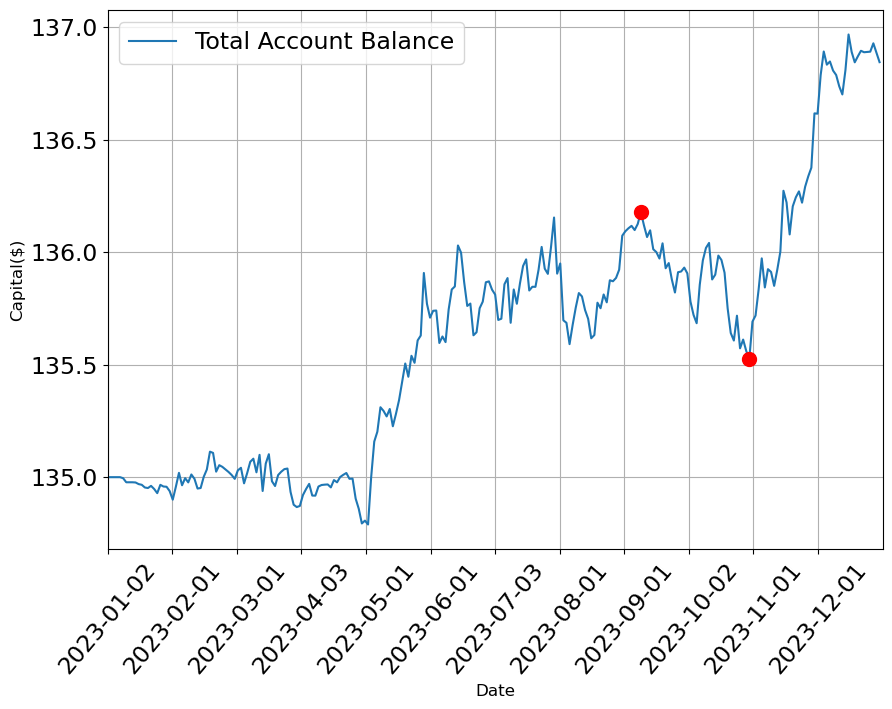

In [17]:
#print('\n')
results, pairs_summary = trader.summarize_results(sharperatio_val,
                                                  cumret_val,
                                                  performance_rnn,
                                                  pairs, ticker_segment_dict,
                                                  n_years=1)

In [18]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,SOXX,iShares Semiconductor ETF,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.917799,0.001908,98,41,0.348657,1,0,2.189070,100.0
1,SOXX,iShares Semiconductor ETF,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.917799,0.001908,98,41,0.348657,1,0,2.177336,100.0
2,SOXX,iShares Semiconductor ETF,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.917799,0.001908,98,41,0.348657,1,0,2.177336,100.0
3,SOXX,iShares Semiconductor ETF,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.917799,0.001908,98,41,0.348657,1,0,2.177336,100.0
4,VTIP,Vanguard Short-Term Inflation-Protected Securi...,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.937487,0.001776,67,33,0.317778,1,0,1.872870,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,SHV,iShares Short Treasury Bond ETF,FTSM,First Trust Enhanced Short Maturity ETF,-3.701196,0.004096,38,47,0.352930,0,15,-4.171700,0.0
131,SHV,iShares Short Treasury Bond ETF,FTSM,First Trust Enhanced Short Maturity ETF,-3.701196,0.004096,38,47,0.352930,0,16,-4.410320,0.0
132,SHV,iShares Short Treasury Bond ETF,FTSM,First Trust Enhanced Short Maturity ETF,-3.701196,0.004096,38,47,0.352930,0,19,-4.737381,0.0
133,SHV,iShares Short Treasury Bond ETF,FTSM,First Trust Enhanced Short Maturity ETF,-3.701196,0.004096,38,47,0.352930,0,21,-4.875366,0.0


In [19]:
results

{'n_pairs': 135,
 'portfolio_sharpe_ratio': np.float64(1.5548246738402032),
 'avg_total_roi': np.float64(1.366593203803311),
 'avg_annual_roi': np.float64(1.3665932038033013),
 'pct_positive_trades_per_pair': np.float64(49.51690821256038),
 'pct_pairs_with_positive_results': 26.666666666666668,
 'avg_half_life': np.float64(42.925925925925924),
 'avg_hurst_exponent': np.float64(0.37497775544053935)}

Training:

In [20]:
init = model_rnn[0]['predictions_train'].index[0]
true_train = [pairs[i][2]['spread'][init:train_val_split] for i in range(len(pairs))]
predictions_train = [model_rnn[i]['predictions_train'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_train, predictions_train)

2579.77E-4
335.71E-3
236.19E-3
49.46%


Validation:

In [21]:
true_val = [summaries_rnn[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_rnn[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_val, predictions)

4121.22E-4
365.92E-3
277.32E-3
48.91%


### **Test unrestricted**

In [22]:
current_path=('/mnt/d/GitHub/WQU-Capstone/models/lstm/')

model_rnn, cumret_test, sharperatio_test, summaries_rnn, balance_summaries_rnn = \
        forecasting_trader.test_specific_model(n_in, hidden_nodes, pairs, path=current_path,
                                               low_quantile=low_quantile, high_quantile=high_quantile, lag=1, 
                                               profitable_pairs_indices=range(len(pairs)))

performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(pairs))]
performance_rnn

Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not cons

[(            prediction(t)  prediction(t+1)  spread(t)  predicted_change(%)  \
  Date                                                                         
  2024-02-06       3.234875                0   3.229728             0.000000   
  2024-02-07       3.193757                0   3.244741            -1.113730   
  2024-02-08       3.187021                0   3.293195            -1.778878   
  2024-02-09       3.210356                0   3.243033            -2.515473   
  2024-02-12       3.191740                0   3.216053            -1.581644   
  ...                   ...              ...        ...                  ...   
  2024-12-24       4.169774                0   4.896756           -13.739741   
  2024-12-26       4.205095                0   4.889714           -14.124870   
  2024-12-27       4.226392                0   4.842267           -13.565663   
  2024-12-30       4.231894                0   4.841178           -12.605120   
  2024-12-31       4.234737             

Annual ROI:  0.050079609052589014
24.444444444444443 % of the pairs had positive returns
Not considering risk-free rate
Total number of trades:  363
Positive trades:  145
Negative trades:  218
Total Drawdown Days: 117 days
Max DD period: 1 days
Maximum drawdown of portfolio: -1.10%


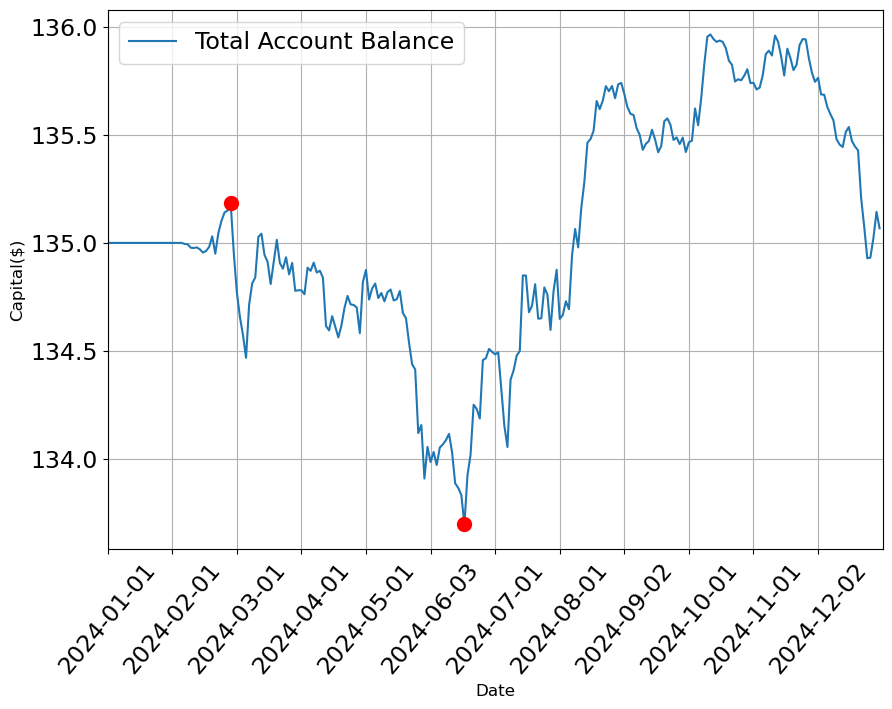

In [23]:
results, pairs_summary = trader.summarize_results(sharperatio_test,
                                                  cumret_test,
                                                  performance_rnn,
                                                  pairs, ticker_segment_dict,
                                                  n_years=1)

In [24]:
results

{'n_pairs': 135,
 'portfolio_sharpe_ratio': np.float64(0.04588702114688141),
 'avg_total_roi': np.float64(0.050079609052585496),
 'avg_annual_roi': np.float64(0.050079609052589014),
 'pct_positive_trades_per_pair': np.float64(25.560260995043603),
 'pct_pairs_with_positive_results': 24.444444444444443,
 'avg_half_life': np.float64(42.925925925925924),
 'avg_hurst_exponent': np.float64(0.3749777554405394)}

In [25]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,VTIP,Vanguard Short-Term Inflation-Protected Securi...,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.937487,0.001776,67,33,0.317778,2,0,1.662908,100.0
1,VTIP,Vanguard Short-Term Inflation-Protected Securi...,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.937487,0.001776,67,33,0.317778,2,0,1.662908,100.0
2,VTIP,Vanguard Short-Term Inflation-Protected Securi...,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.937487,0.001776,67,33,0.317778,2,0,1.642553,100.0
3,VTIP,Vanguard Short-Term Inflation-Protected Securi...,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.937487,0.001776,67,33,0.317778,2,0,1.642553,100.0
4,ACWI,iShares MSCI ACWI ETF,SOXX,iShares Semiconductor ETF,-3.773799,0.003187,101,42,0.367857,4,0,1.439840,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,SHV,iShares Short Treasury Bond ETF,FTSM,First Trust Enhanced Short Maturity ETF,-3.701196,0.004096,38,47,0.352930,0,14,-4.228444,0.0
131,SHV,iShares Short Treasury Bond ETF,FTSM,First Trust Enhanced Short Maturity ETF,-3.701196,0.004096,38,47,0.352930,0,9,-4.444154,0.0
132,SHV,iShares Short Treasury Bond ETF,FTSM,First Trust Enhanced Short Maturity ETF,-3.701196,0.004096,38,47,0.352930,0,11,-4.473438,0.0
133,SHV,iShares Short Treasury Bond ETF,FTSM,First Trust Enhanced Short Maturity ETF,-3.701196,0.004096,38,47,0.352930,0,9,-4.547659,0.0


Test:

In [26]:
true_test = [summaries_rnn[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_rnn[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_test, predictions)

18751.04E-4
648.80E-3
495.80E-3
47.38%


### **Test with active pairs on validation set**

In [27]:
cumret_val = np.asarray(cumret_val)
profitable_pairs_indices = np.argwhere(cumret_val > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]
model_rnn, cumret_test, sharperatio_test, summaries_rnn, balance_summaries_rnn = \
        forecasting_trader.test_specific_model(n_in, hidden_nodes, pairs, path=current_path,
                                               low_quantile=low_quantile, high_quantile=high_quantile, lag=1, 
                                               profitable_pairs_indices=profitable_pairs_indices)
performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(profitable_pairs))]
performance_rnn

Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not cons

[(            prediction(t)  prediction(t+1)   spread(t)  predicted_change(%)  \
  Date                                                                          
  2024-02-06      48.284405                0   50.968684             0.000000   
  2024-02-07      51.516006                0   49.623926             1.073840   
  2024-02-08      50.401318                0   43.899642             1.566566   
  2024-02-09      45.527500                0   40.447289             3.708135   
  2024-02-12      42.440178                0   39.462347             4.927127   
  ...                   ...              ...         ...                  ...   
  2024-12-24     100.771118                0  107.291572            -3.581138   
  2024-12-26     105.348305                0  107.064158            -1.811202   
  2024-12-27     104.383324                0  103.600594            -2.503951   
  2024-12-30     100.645477                0  104.887222            -2.852413   
  2024-12-31     102.770523 

Annual ROI:  2.433292452557523
63.888888888888886 % of the pairs had positive returns
Not considering risk-free rate
Total number of trades:  188
Positive trades:  110
Negative trades:  78
Total Drawdown Days: 109 days
Max DD period: 1 days
Maximum drawdown of portfolio: -3.70%


{'n_pairs': 36,
 'portfolio_sharpe_ratio': np.float64(0.6763807033737328),
 'avg_total_roi': np.float64(2.433292452557523),
 'avg_annual_roi': np.float64(2.433292452557523),
 'pct_positive_trades_per_pair': np.float64(48.37793193693815),
 'pct_pairs_with_positive_results': 63.888888888888886,
 'avg_half_life': np.float64(43.861111111111114),
 'avg_hurst_exponent': np.float64(0.36811620032821896)}

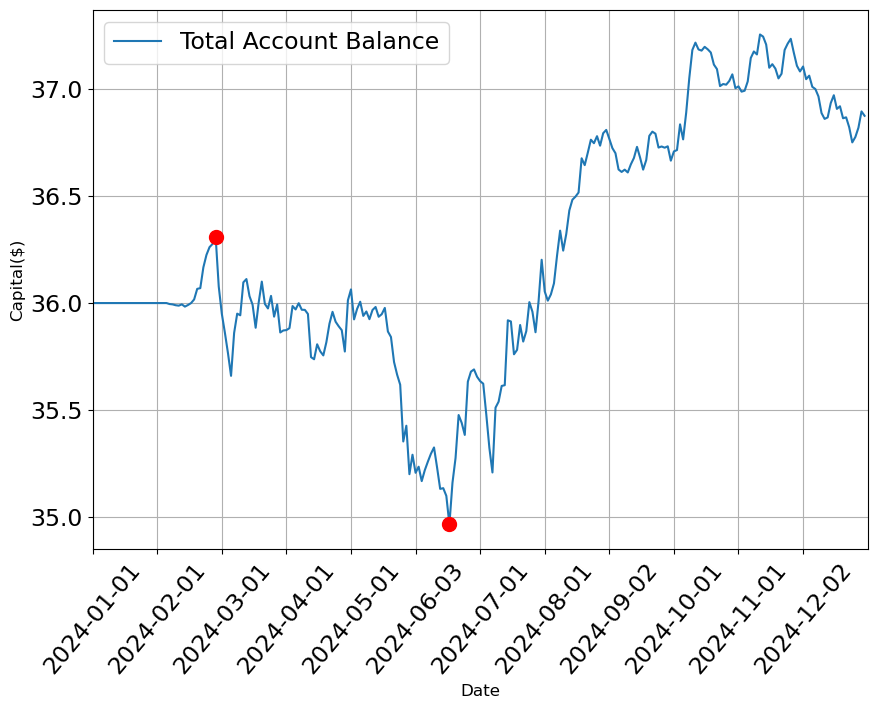

In [29]:
results, pairs_summary = trader.summarize_results(sharperatio_test,
                                                  cumret_test,
                                                  performance_rnn,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years=1)
results

In [30]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,VTIP,Vanguard Short-Term Inflation-Protected Securi...,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.937487,0.001776,67,33,0.317778,2,0,1.662908,100.000000
1,VTIP,Vanguard Short-Term Inflation-Protected Securi...,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.937487,0.001776,67,33,0.317778,2,0,1.662908,100.000000
2,VTIP,Vanguard Short-Term Inflation-Protected Securi...,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.937487,0.001776,67,33,0.317778,2,0,1.642553,100.000000
3,VTIP,Vanguard Short-Term Inflation-Protected Securi...,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.937487,0.001776,67,33,0.317778,2,0,1.642553,100.000000
4,SOXX,iShares Semiconductor ETF,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.917799,0.001908,98,41,0.348657,2,2,1.257429,50.000000
5,TQQQ,ProShares UltraPro QQQ,PFF,iShares Preferred and Income Securities ETF,-4.255513,0.000530,44,29,0.316001,1,1,1.249218,50.000000
6,QQQ,Invesco QQQ Trust,SOXX,iShares Semiconductor ETF,-3.602552,0.005712,72,40,0.398305,12,3,0.961783,80.000000
7,SOXX,iShares Semiconductor ETF,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.917799,0.001908,98,41,0.348657,2,2,0.814537,50.000000
8,QQQ,Invesco QQQ Trust,SOXX,iShares Semiconductor ETF,-3.602552,0.005712,72,40,0.398305,9,3,0.580775,75.000000
9,SOXX,iShares Semiconductor ETF,CIBR,First Trust NASDAQ Cybersecurity ETF,-3.917799,0.001908,98,41,0.348657,2,2,0.578726,50.000000
